<a href="https://colab.research.google.com/github/zjzsu2000/CMPE258/blob/master/homework_1/fastai_ex__lesson2_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating your own dataset from Google Images
using other data

In [1]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [55]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'CMPE258/fastai-v3/'

Mounted at /content/gdrive


In [0]:
from fastai.vision import *

## Get a list of URLs

### Search and scroll of "panda","bear","lion"
download to csv files.

using javascript command
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

### Create directory and upload urls file

In [0]:
folder1 = 'panda'
file1 = 'panda.csv'

In [0]:
folder2 = 'bear'
file2 = 'bear.csv'

In [0]:
folder3 = 'lion'
file3 = 'lion.csv'

You will need to run this cell once per each category.

In [0]:
path = Path(base_dir + 'data')
dest1 = path/folder1
dest1.mkdir(parents=True, exist_ok=True)
dest2 = path/folder2
dest2.mkdir(parents=True, exist_ok=True)
dest3 = path/folder3
dest3.mkdir(parents=True, exist_ok=True)

In [61]:
path.ls()

[PosixPath('/content/gdrive/My Drive/CMPE258/fastai-v3/data/panda'),
 PosixPath('/content/gdrive/My Drive/CMPE258/fastai-v3/data/bear'),
 PosixPath('/content/gdrive/My Drive/CMPE258/fastai-v3/data/lion'),
 PosixPath('/content/gdrive/My Drive/CMPE258/fastai-v3/data/models'),
 PosixPath('/content/gdrive/My Drive/CMPE258/fastai-v3/data/cleaned.csv'),
 PosixPath('/content/gdrive/My Drive/CMPE258/fastai-v3/data/export.pkl')]

## Download images

In [0]:
classes = ['panda','bear','lion']

In [0]:
import pandas as pd


In [64]:
#Reading in the data as a Pandas dataframe to skip_blank_lines
urls1 = pd.read_csv(dest1/file1,skip_blank_lines=True)
urls1.shape


(419, 1)

In [0]:
urls1.to_csv(dest1/file1,index=None)#write back to file

In [66]:
download_images(dest1/file1, dest1, max_pics=300)

In [67]:
#Reading in the data as a Pandas dataframe to skip_blank_lines
urls2 = pd.read_csv(dest2/file2,skip_blank_lines=True)
urls2.shape


(659, 1)

In [0]:
urls2.to_csv(dest2/file2,index=None)#write back to file

In [69]:
download_images(dest2/file2, dest2, max_pics=300)

In [70]:
#Reading in the data as a Pandas dataframe to skip_blank_lines
urls3 = pd.read_csv(dest3/file3,skip_blank_lines=True)
urls3.shape

(602, 1)

In [0]:
urls3.to_csv(dest3/file3,index=None)#write back to file

In [73]:
download_images(dest3/file3, dest3, max_pics=300)

remove any images that can't be opened:

In [74]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

panda


bear


lion


## View data

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [76]:
data.classes

['bear', 'lion', 'panda']

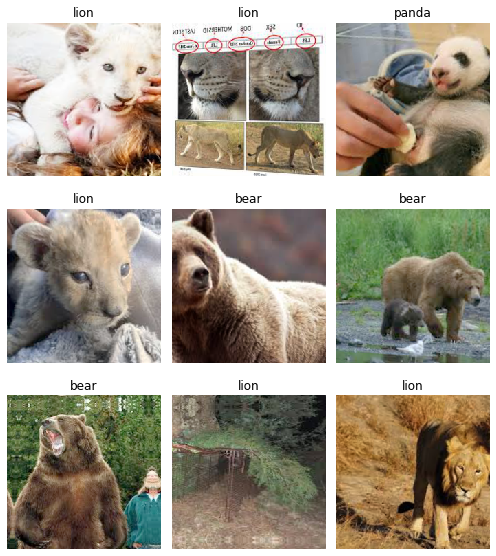

In [77]:
data.show_batch(rows=3, figsize=(7,8))

In [79]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['bear', 'lion', 'panda'], 3, 848, 212)

## Train model

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [81]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.898073,0.156957,0.047170,00:11
1,0.529872,0.141531,0.033019,00:11
2,0.367715,0.136932,0.037736,00:11
3,0.272896,0.128090,0.033019,00:11


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [84]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


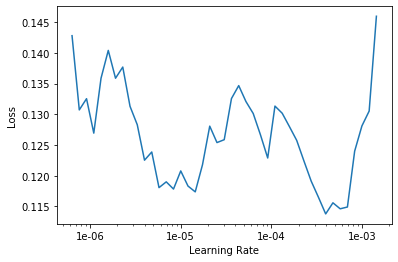

In [85]:
learn.recorder.plot()

In [86]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.092604,0.139988,0.033019,00:11
1,0.086036,0.131255,0.033019,00:11


In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2');

In [89]:
interp = ClassificationInterpretation.from_learner(learn)

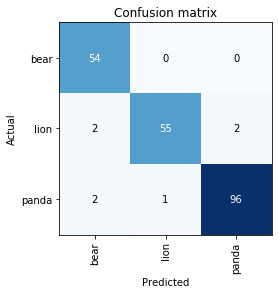

In [90]:
interp.plot_confusion_matrix()

## Cleaning Up



In [0]:
from fastai.widgets import *

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

create a new learner to use new databunch with all the images.

In [0]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [94]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [95]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


## Putting your model in production

In [0]:
learn.export()

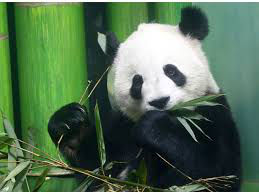

In [42]:
img = open_image(path/'panda'/'00000021.jpg')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [0]:
learn = load_learner(path)

In [98]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category panda

### Learning rate (LR) too high

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [100]:
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,23.332878,24366718.000000,0.721698,00:11


### Learning rate (LR) too low

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [102]:
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,2.080374,1.564735,0.712264,00:10
1,1.957218,1.311359,0.608491,00:11
2,1.950917,1.238086,0.570755,00:11
3,1.891044,1.172271,0.542453,00:11
4,1.845796,1.161296,0.547170,00:10


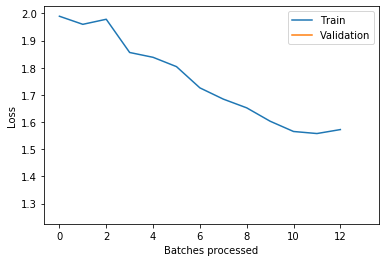

In [105]:
learn.recorder.plot_losses()

### Too few epochs

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [104]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.572508,1.262276,0.627358,00:11


### Too many epochs

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [53]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [54]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.643946,2.380558,0.588050,00:09
1,1.527641,1.811291,0.578616,00:07
2,1.471219,1.389515,0.541929,00:07
3,1.320207,1.062725,0.462264,00:07
4,1.184005,0.816014,0.342767,00:07
5,1.037195,0.600485,0.243187,00:07
6,0.914068,0.465118,0.172956,00:07
7,0.797048,0.370467,0.128931,00:07
8,0.695499,0.327222,0.116352,00:07
9,0.611613,0.297049,0.103774,00:07
